### Check GPU

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import PIL.Image
import matplotlib.pyplot as plt

from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import models
from tqdm.notebook import tqdm


In [3]:
from tensorboard import version; print(version.VERSION)

2.4.1


In [4]:
# check GPU support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset and dataloader

In [5]:
PATH = 'C:/Users/trang/OneDrive - HKUST Connect/COMP_4211/pa2/' 

- resize all the images to a size of 32x32
- convert them to single-channel images

Dataset.getitem() should return:
- two 32x32, single-channel images
- one target label

In [6]:
class ImageDataset(Dataset):
    def __init__(self, info_file, index_file, image_dir, transform=None):
        self.info_df = pd.read_csv(info_file)  
        self.index_df = pd.read_csv(index_file, sep=',',header =None,names=['index','source'])
        #self.classes = np.array(self.info_df.columns[1:]) # image labels 
        self.image_dir = image_dir
        self.transform = transform

    def __getitem__(self, idx):
        img_index1 = self.info_df.iloc[idx, 0]
        img_name1 = os.path.join(self.image_dir, str(self.index_df.iloc[img_index1-1, 1])[5:])
        image1 = PIL.Image.open(img_name1)
        image1 = image1.convert('L')
        
        img_index2 = self.info_df.iloc[idx, 1]
        img_name2 = os.path.join(self.image_dir, str(self.index_df.iloc[img_index2-1, 1])[5:])
        image2 = PIL.Image.open(img_name2)
        image2 = image2.convert('L')
        
        label = self.info_df.iloc[idx, 2]
        
        if self.transform is not None:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        
        return image1, image2, label

    def __len__(self):
        return len(self.info_df)

Check dataset

In [7]:
# more transform functions can refer to https://pytorch.org/docs/stable/torchvision/transforms.html
transform = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),    # range [0, 255]  -> [0.0,1.0] Convert a PIL Image or numpy.ndarray (H x W x C)  to tensor (C x H x W) 
     transforms.Normalize((0.5,), (0.5,))   # channel=（channel-mean）/std  -> [-1, 1]
     ])

# if the image has one channel (grayscale), normalise operation will be 
#transforms.Normalize((0.5, ), (0.5, ))

In [8]:
dataset = ImageDataset(PATH + 'train.csv', PATH + 'index.txt',PATH, transform=transform)

Load image dataset

In [9]:
train_set = ImageDataset(PATH + 'train.csv', PATH + 'index.txt', PATH, transform=transform)
valid_set = ImageDataset(PATH + 'valid.csv', PATH + 'index.txt', PATH, transform=transform)
test_set = ImageDataset(PATH + 'test.csv', PATH + 'index.txt', PATH, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128,shuffle=False)


### Define Convolutional Neural Network

In [2]:
class SiameseNetwork(nn.Module):
    def __init__(self, aggregation_type):
        super(SiameseNetwork, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding = 1), 
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1),  
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.AvgPool2d(kernel_size=16,stride=1),
            
            nn.Flatten(),
            
        )
        self.aggregation_type = aggregation_type
        if(self.aggregation_type=="concatenation"):
            self.fc1 = nn.Linear(1024,512) # concatenation
        elif(self.aggregation_type=="absolute_substraction"):
            self.fc1 = nn.Linear(512,512) # absolute substraction
        self.drop_out = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512,1)

    def forward(self, image1, image2):
        
        image1 = self.cnn(image1)
        image2 = self.cnn(image2)
        
        if(self.aggregation_type=="concatenation"):
            h3 = torch.cat((image1,image2),1) #concatenation
        elif(self.aggregation_type=="absolute_substraction"):
            h3 = torch.abs(torch.sub(image1, image2)) #absolute substraction

        output = F.relu(self.fc1(h3))
        output = self.drop_out(output)
        output = self.fc2(output)
        output = nn.Sigmoid()(output)
        #output = torch.reshape(output,(-1,))
        
        return output

#### Function count the total number of trainable parameters

When aggregation function is absolute difference

In [3]:
from torchsummaryX import summary

model = SiameseNetwork('absolute_substraction').cuda()
summary(model, torch.zeros((128, 1, 32, 32)).cuda(), torch.zeros((128, 1, 32, 32)).cuda())


                           Kernel Shape        Output Shape    Params  \
Layer                                                                   
0_cnn.Conv2d_0            [1, 32, 3, 3]   [128, 32, 32, 32]     320.0   
1_cnn.BatchNorm2d_1                [32]   [128, 32, 32, 32]      64.0   
2_cnn.ReLU_2                          -   [128, 32, 32, 32]         -   
3_cnn.Conv2d_3           [32, 32, 3, 3]   [128, 32, 32, 32]    9.248k   
4_cnn.BatchNorm2d_4                [32]   [128, 32, 32, 32]      64.0   
5_cnn.ReLU_5                          -   [128, 32, 32, 32]         -   
6_cnn.MaxPool2d_6                     -   [128, 32, 16, 16]         -   
7_cnn.Conv2d_7           [32, 64, 3, 3]   [128, 64, 16, 16]   18.496k   
8_cnn.BatchNorm2d_8                [64]   [128, 64, 16, 16]     128.0   
9_cnn.ReLU_9                          -   [128, 64, 16, 16]         -   
10_cnn.Conv2d_10        [64, 128, 3, 3]  [128, 128, 16, 16]   73.856k   
11_cnn.BatchNorm2d_11             [128]  [128, 128,

Kernel Shape        Output Shape     Params  \
Layer                                                                    
0_cnn.Conv2d_0            [1, 32, 3, 3]   [128, 32, 32, 32]      320.0   
1_cnn.BatchNorm2d_1                [32]   [128, 32, 32, 32]       64.0   
2_cnn.ReLU_2                          -   [128, 32, 32, 32]        NaN   
3_cnn.Conv2d_3           [32, 32, 3, 3]   [128, 32, 32, 32]     9248.0   
4_cnn.BatchNorm2d_4                [32]   [128, 32, 32, 32]       64.0   
5_cnn.ReLU_5                          -   [128, 32, 32, 32]        NaN   
6_cnn.MaxPool2d_6                     -   [128, 32, 16, 16]        NaN   
7_cnn.Conv2d_7           [32, 64, 3, 3]   [128, 64, 16, 16]    18496.0   
8_cnn.BatchNorm2d_8                [64]   [128, 64, 16, 16]      128.0   
9_cnn.ReLU_9                          -   [128, 64, 16, 16]        NaN   
10_cnn.Conv2d_10        [64, 128, 3, 3]  [128, 128, 16, 16]    73856.0   
11_cnn.BatchNorm2d_11             [128]  [128, 128, 16, 16]      256.0   
12_cnn.ReLU_12                        -  [128, 128, 16, 16]        NaN   
13_cnn.Conv2d_13       [128, 256, 3, 3]  [128, 256, 16, 16]   295168.0   
14_cnn.BatchNorm2d_14             [256]  [128, 256, 16, 16]      512.0   
15_cnn.ReLU_15                        -  [128, 256, 16, 16]        NaN   
16_cnn.Conv2d_16       [256, 512, 3, 3]  [128, 512, 16, 16]  1180160.0   
17_cnn.BatchNorm2d_17             [512]  [128, 512, 16, 16]     1024.0   
18_cnn.ReLU_18                        -  [128, 512, 16, 16]        NaN   
19_cnn.AvgPool2d_19                   -    [128, 512, 1, 1]        NaN   
20_cnn.Flatten_20                     -          [128, 512]        NaN   
21_cnn.Conv2d_0           [1, 32, 3, 3]   [128, 32, 32, 32]        NaN   
22_cnn.BatchNorm2d_1               [32]   [128, 32, 32, 32]        NaN   
23_cnn.ReLU_2                         -   [128, 32, 32, 32]        NaN   
24_cnn.Conv2d_3          [32, 32, 3, 3]   [128, 32, 32, 32]        NaN   
25_cnn.BatchNorm2d_4               [32]   [128, 32, 32, 32]        NaN   
26_cnn.ReLU_5                         -   [128, 32, 32, 32]        NaN   
27_cnn.MaxPool2d_6                    -   [128, 32, 16, 16]        NaN   
28_cnn.Conv2d_7          [32, 64, 3, 3]   [128, 64, 16, 16]        NaN   
29_cnn.BatchNorm2d_8               [64]   [128, 64, 16, 16]        NaN   
30_cnn.ReLU_9                         -   [128, 64, 16, 16]        NaN   
31_cnn.Conv2d_10        [64, 128, 3, 3]  [128, 128, 16, 16]        NaN   
32_cnn.BatchNorm2d_11             [128]  [128, 128, 16, 16]        NaN   
33_cnn.ReLU_12                        -  [128, 128, 16, 16]        NaN   
34_cnn.Conv2d_13       [128, 256, 3, 3]  [128, 256, 16, 16]        NaN   
35_cnn.BatchNorm2d_14             [256]  [128, 256, 16, 16]        NaN   
36_cnn.ReLU_15                        -  [128, 256, 16, 16]        NaN   
37_cnn.Conv2d_16       [256, 512, 3, 3]  [128, 512, 16, 16]        NaN   
38_cnn.BatchNorm2d_17             [512]  [128, 512, 16, 16]        NaN   
39_cnn.ReLU_18                        -  [128, 512, 16, 16]        NaN   
40_cnn.AvgPool2d_19                   -    [128, 512, 1, 1]        NaN   
41_cnn.Flatten_20                     -          [128, 512]        NaN   
42_fc1                       [512, 512]          [128, 512]   262656.0   
43_drop_out                           -          [128, 512]        NaN   
44_fc2                         [512, 1]            [128, 1]      513.0   

                         Mult-Adds  
Layer                               
0_cnn.Conv2d_0            294912.0  
1_cnn.BatchNorm2d_1           32.0  
2_cnn.ReLU_2                   NaN  
3_cnn.Conv2d_3           9437184.0  
4_cnn.BatchNorm2d_4           32.0  
5_cnn.ReLU_5                   NaN  
6_cnn.MaxPool2d_6              NaN  
7_cnn.Conv2d_7           4718592.0  
8_cnn.BatchNorm2d_8           64.0  
9_cnn.ReLU_9                   NaN  
10_cnn.Conv2d_10        18874368.0  
11_cnn.BatchNorm2d_11        128.0  
12_cnn.ReLU_12                

In [11]:
net_absolute_substraction = SiameseNetwork("absolute_substraction").cuda()
summary(net_absolute_substraction, [(1, 32, 32),(1, 32, 32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

When aggregation function is concatenation

In [12]:
net_concatenation = SiameseNetwork("concatenation").cuda()
summary(net_concatenation, [(1, 32, 32),(1,32,32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

### 4.2.3 Training and Validation

In [13]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to {save_path}')

def load_checkpoint(save_path, model, optimizer):
    save_path = save_path #f'cifar_net.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from {save_path}, with val loss: {val_loss}')
    return val_loss

def TRAIN(net, train_loader, valid_loader,  num_epochs, criterion, optimizer, val_loss,threshold, device, save_name):
    
    step_list = []
    training_loss_list = []
    valid_loss_list = []
    
    if val_loss==None:
        best_val_loss = float("Inf")  
    else: 
        best_val_loss=val_loss
        print('Resume training')


    no_step = 0;
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        net.train()
        running_loss = 0.0
        running_corrects = 0
        for input1,input2, labels in tqdm(train_loader):
            
            no_step +=1
            input1 = input1.to(device)
            input2 = input2.to(device)
            labels = labels.to(device)
            
            labels = labels.unsqueeze(1)
            labels = labels.float()

            '''Training of the model'''
            # Forward pass
            outputs = net(input1, input2)
            
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss = loss.item()
            running_loss += loss.item()
            preds = torch.gt(outputs, threshold).int()                       
            running_corrects += torch.sum(preds == labels.data.int())            
            
            with torch.no_grad():
                net.eval()
                running_loss_valid = 0.0
                running_corrects_valid = 0
                for input1_valid,input2_valid, labels_valid in tqdm(valid_loader):
            
                    input1_valid = input1_valid.to(device)
                    input2_valid = input2_valid.to(device)
                    labels_valid = labels_valid.to(device)

                    labels_valid = labels_valid.unsqueeze(1)
                    labels_valid = labels_valid.float()

                    outputs_valid = net(input1_valid,input2_valid)
                    loss_valid = criterion(outputs_valid, labels_valid)

                    running_loss_valid += loss_valid.item()
                    preds_valid = torch.gt(outputs_valid, threshold).int()
                    running_corrects_valid += torch.sum(preds_valid == labels_valid.data.int())

                valid_loss = running_loss_valid / len(valid_loader)
                valid_acc = running_corrects_valid / float(len(valid_loader.dataset))
            
            if(no_step%10==0):
                step_list.append(no_step)
                training_loss_list.append(training_loss)
                valid_loss_list.append(valid_loss)
                
                print("step ",no_step," training loss: ",training_loss,", validation loss: ",valid_loss,"\n")
            

        train_loss = running_loss / len(train_loader)
        train_acc = running_corrects / float(len(train_loader.dataset))

        with torch.no_grad():
            net.eval()
            running_loss = 0.0
            running_corrects = 0
            for input1,input2, labels in tqdm(valid_loader):
            
                input1 = input1.to(device)
                input2 = input2.to(device)
                labels = labels.to(device)
                
                labels = labels.unsqueeze(1)
                labels = labels.float()

                outputs = net(input1,input2)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                preds = torch.gt(outputs, threshold).float()
                running_corrects += torch.sum(preds == labels.data)

            valid_loss = running_loss / len(valid_loader)
            valid_acc = running_corrects / float(len(valid_loader.dataset))

        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            save_checkpoint(save_name, net, optimizer, best_val_loss)
    
    plt.plot(step_list,training_loss_list,label="Training Loss")
    plt.plot(step_list,valid_loss_list,label="Validation Loss")
    plt.xlabel('Number of steps')
    # Set a title of the current axes.
    plt.title('Traning and Validation loss curves')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()
    
    print('Finished Training')


step  10  training loss:  0.6949416995048523 , validation loss:  0.6941604415575663 




step  20  training loss:  0.6940991282463074 , validation loss:  0.6939630508422852 




step  30  training loss:  0.6927279233932495 , validation loss:  0.6937702298164368 




Epoch [1/25], Train Loss: 0.6931, Train Acc: 0.5020, Valid Loss: 0.6932,  Valid Acc: 0.5329
Model saved to cifar_net.pt



step  40  training loss:  0.6899116635322571 , validation loss:  0.6935407320658366 




step  50  training loss:  0.6927143931388855 , validation loss:  0.6925762097040812 




step  60  training loss:  0.6878000497817993 , validation loss:  0.6910211145877838 




step  70  training loss:  0.6868466138839722 , validation loss:  0.6873066524664561 




Epoch [2/25], Train Loss: 0.6910, Train Acc: 0.5392, Valid Loss: 0.6843,  Valid Acc: 0.4986
Model saved to cifar_net.pt



step  80  training loss:  0.6797775030136108 , validation loss:  0.6839033464590708 




step  90  training loss:  0.6816840171813965 , validation loss:  0.6807032724221548 




step  100  training loss:  0.6789395809173584 , validation loss:  0.6844493349393209 




step  110  training loss:  0.6958678960800171 , validation loss:  0.6824407676855723 




Epoch [3/25], Train Loss: 0.6864, Train Acc: 0.5345, Valid Loss: 0.6836,  Valid Acc: 0.5429
Model saved to cifar_net.pt



step  120  training loss:  0.6750560402870178 , validation loss:  0.6805130143960317 




step  130  training loss:  0.6759825944900513 , validation loss:  0.6795391241709391 




step  140  training loss:  0.6982851028442383 , validation loss:  0.6813627978165945 




step  150  training loss:  0.6863213181495667 , validation loss:  0.6799453596274058 




Epoch [4/25], Train Loss: 0.6837, Train Acc: 0.5598, Valid Loss: 0.6780,  Valid Acc: 0.5714
Model saved to cifar_net.pt



step  160  training loss:  0.6824514269828796 , validation loss:  0.6868216196695963 




step  170  training loss:  0.6828590035438538 , validation loss:  0.6767363250255585 




step  180  training loss:  0.682703971862793 , validation loss:  0.6844112376372019 




step  190  training loss:  0.6843948364257812 , validation loss:  0.6806615094343821 




Epoch [5/25], Train Loss: 0.6828, Train Acc: 0.5622, Valid Loss: 0.6782,  Valid Acc: 0.5514



step  200  training loss:  0.6874840259552002 , validation loss:  0.6818739672501882 




step  210  training loss:  0.6727775931358337 , validation loss:  0.6800140142440796 




step  220  training loss:  0.6778750419616699 , validation loss:  0.6779885093371073 




step  230  training loss:  0.6653376221656799 , validation loss:  0.6676844855149587 




Epoch [6/25], Train Loss: 0.6778, Train Acc: 0.5818, Valid Loss: 0.6673,  Valid Acc: 0.5700
Model saved to cifar_net.pt



step  240  training loss:  0.6755396127700806 , validation loss:  0.6762352188428243 




step  250  training loss:  0.6625393033027649 , validation loss:  0.6618822515010834 




step  260  training loss:  0.6814092993736267 , validation loss:  0.6770090659459432 




step  270  training loss:  0.6674091815948486 , validation loss:  0.6623149514198303 




Epoch [7/25], Train Loss: 0.6721, Train Acc: 0.5869, Valid Loss: 0.6757,  Valid Acc: 0.6271



step  280  training loss:  0.6463387608528137 , validation loss:  0.6605028013388315 




step  290  training loss:  0.673306941986084 , validation loss:  0.67311359445254 




step  300  training loss:  0.682948112487793 , validation loss:  0.6551652699708939 




step  310  training loss:  0.6473895311355591 , validation loss:  0.6645405987898508 




Epoch [8/25], Train Loss: 0.6653, Train Acc: 0.6080, Valid Loss: 0.6704,  Valid Acc: 0.6000



step  320  training loss:  0.6424411535263062 , validation loss:  0.6519473642110825 




step  330  training loss:  0.6491219997406006 , validation loss:  0.6630788147449493 




step  340  training loss:  0.652739405632019 , validation loss:  0.6570613086223602 




step  350  training loss:  0.6862599849700928 , validation loss:  0.6410666207472483 




Epoch [9/25], Train Loss: 0.6550, Train Acc: 0.6190, Valid Loss: 0.6508,  Valid Acc: 0.6343
Model saved to cifar_net.pt



step  360  training loss:  0.636717677116394 , validation loss:  0.6428853174050649 




step  370  training loss:  0.6477584838867188 , validation loss:  0.6438839733600616 




step  380  training loss:  0.6161537170410156 , validation loss:  0.6270444293816885 




step  390  training loss:  0.6586083173751831 , validation loss:  0.6499601503213247 





Epoch [10/25], Train Loss: 0.6377, Train Acc: 0.6457, Valid Loss: 0.6500,  Valid Acc: 0.6557
Model saved to cifar_net.pt



step  400  training loss:  0.6267489194869995 , validation loss:  0.614278107881546 




step  410  training loss:  0.6209095120429993 , validation loss:  0.615624005595843 




step  420  training loss:  0.6050304174423218 , validation loss:  0.6080122391382853 




Epoch [11/25], Train Loss: 0.6131, Train Acc: 0.6604, Valid Loss: 0.5991,  Valid Acc: 0.6814
Model saved to cifar_net.pt



step  430  training loss:  0.6817917823791504 , validation loss:  0.6141254603862762 




step  440  training loss:  0.6322954297065735 , validation loss:  0.5912562608718872 




step  450  training loss:  0.5739542841911316 , validation loss:  0.5891477465629578 




step  460  training loss:  0.5530860424041748 , validation loss:  0.599494049946467 




Epoch [12/25], Train Loss: 0.6069, Train Acc: 0.6696, Valid Loss: 0.5760,  Valid Acc: 0.6629
Model saved to cifar_net.pt



step  470  training loss:  0.6130231618881226 , validation loss:  0.5873207946618398 




step  480  training loss:  0.5980912446975708 , validation loss:  0.5897253155708313 




step  490  training loss:  0.5528678894042969 , validation loss:  0.5707814494768778 




step  500  training loss:  0.5210494995117188 , validation loss:  0.5757036507129669 




Epoch [13/25], Train Loss: 0.5818, Train Acc: 0.6943, Valid Loss: 0.5579,  Valid Acc: 0.6829
Model saved to cifar_net.pt



step  510  training loss:  0.5915051102638245 , validation loss:  0.5665030181407928 




step  520  training loss:  0.6131417751312256 , validation loss:  0.5552785793940226 




step  530  training loss:  0.5465407967567444 , validation loss:  0.5487784594297409 




step  540  training loss:  0.582245945930481 , validation loss:  0.5547777314980825 




Epoch [14/25], Train Loss: 0.5585, Train Acc: 0.7073, Valid Loss: 0.5819,  Valid Acc: 0.7000



step  550  training loss:  0.5891013145446777 , validation loss:  0.5618863801161448 




step  560  training loss:  0.4884844422340393 , validation loss:  0.5725753804047903 




step  570  training loss:  0.5342215299606323 , validation loss:  0.5583618779977163 




step  580  training loss:  0.5226359963417053 , validation loss:  0.5408340891202291 




Epoch [15/25], Train Loss: 0.5450, Train Acc: 0.7239, Valid Loss: 0.5469,  Valid Acc: 0.7086
Model saved to cifar_net.pt



step  590  training loss:  0.575110912322998 , validation loss:  0.5410492867231369 




step  600  training loss:  0.5136569142341614 , validation loss:  0.5648548106352488 




step  610  training loss:  0.507463812828064 , validation loss:  0.5390392541885376 




step  620  training loss:  0.5827823281288147 , validation loss:  0.5304984500010809 




Epoch [16/25], Train Loss: 0.5289, Train Acc: 0.7261, Valid Loss: 0.5372,  Valid Acc: 0.7171
Model saved to cifar_net.pt



step  630  training loss:  0.5485808849334717 , validation loss:  0.5596294005711874 




step  640  training loss:  0.5807944536209106 , validation loss:  0.5525727818409601 




step  650  training loss:  0.48658543825149536 , validation loss:  0.5268465081850687 




step  660  training loss:  0.545193076133728 , validation loss:  0.5489723086357117 




Epoch [17/25], Train Loss: 0.5202, Train Acc: 0.7382, Valid Loss: 0.5475,  Valid Acc: 0.7157



step  670  training loss:  0.4766686260700226 , validation loss:  0.53105195860068 




step  680  training loss:  0.484516978263855 , validation loss:  0.5344432493050894 




step  690  training loss:  0.43354910612106323 , validation loss:  0.5446993907292684 




step  700  training loss:  0.4839251935482025 , validation loss:  0.530036042133967 




Epoch [18/25], Train Loss: 0.4924, Train Acc: 0.7580, Valid Loss: 0.5360,  Valid Acc: 0.7129
Model saved to cifar_net.pt



step  710  training loss:  0.44130104780197144 , validation loss:  0.5297797719637553 




step  720  training loss:  0.44058895111083984 , validation loss:  0.5265531738599142 




step  730  training loss:  0.44148188829421997 , validation loss:  0.5288303643465042 




step  740  training loss:  0.44912612438201904 , validation loss:  0.5396620233853658 




Epoch [19/25], Train Loss: 0.4752, Train Acc: 0.7729, Valid Loss: 0.5329,  Valid Acc: 0.7257
Model saved to cifar_net.pt



step  750  training loss:  0.44638556241989136 , validation loss:  0.5213767886161804 




step  760  training loss:  0.49726927280426025 , validation loss:  0.5420737167199453 




step  770  training loss:  0.4863938093185425 , validation loss:  0.5632718503475189 




step  780  training loss:  0.37304994463920593 , validation loss:  0.5148516396681467 





Epoch [20/25], Train Loss: 0.4608, Train Acc: 0.7894, Valid Loss: 0.5149,  Valid Acc: 0.7529
Model saved to cifar_net.pt



step  790  training loss:  0.47036802768707275 , validation loss:  0.5271389832099279 




step  800  training loss:  0.3826969265937805 , validation loss:  0.5458595405022303 




step  810  training loss:  0.45230633020401 , validation loss:  0.5213372707366943 




Epoch [21/25], Train Loss: 0.4314, Train Acc: 0.8047, Valid Loss: 0.5276,  Valid Acc: 0.7314



step  820  training loss:  0.4467599391937256 , validation loss:  0.5283806025981903 




step  830  training loss:  0.3621118664741516 , validation loss:  0.5461725244919459 




step  840  training loss:  0.46710634231567383 , validation loss:  0.5438345124324163 




step  850  training loss:  0.3989070951938629 , validation loss:  0.5152867833773295 




Epoch [22/25], Train Loss: 0.4164, Train Acc: 0.8102, Valid Loss: 0.5625,  Valid Acc: 0.7243



step  860  training loss:  0.40174001455307007 , validation loss:  0.589557965596517 




step  870  training loss:  0.3722391128540039 , validation loss:  0.5187704116106033 




step  880  training loss:  0.32793480157852173 , validation loss:  0.5592329899470011 




step  890  training loss:  0.359289288520813 , validation loss:  0.548917273680369 




Epoch [23/25], Train Loss: 0.4033, Train Acc: 0.8167, Valid Loss: 0.5289,  Valid Acc: 0.7186



step  900  training loss:  0.3808489143848419 , validation loss:  0.5400001108646393 




step  910  training loss:  0.3592936396598816 , validation loss:  0.5221341003974279 




step  920  training loss:  0.33868110179901123 , validation loss:  0.5486411452293396 




step  930  training loss:  0.30508697032928467 , validation loss:  0.5564946432908376 




Epoch [24/25], Train Loss: 0.3744, Train Acc: 0.8386, Valid Loss: 0.5519,  Valid Acc: 0.7429



step  940  training loss:  0.3810526728630066 , validation loss:  0.549476886789004 




step  950  training loss:  0.38892921805381775 , validation loss:  0.5708150962988535 




step  960  training loss:  0.3243350684642792 , validation loss:  0.5555929491917292 




step  970  training loss:  0.32713228464126587 , validation loss:  0.5228248635927836 




Epoch [25/25], Train Loss: 0.3580, Train Acc: 0.8504, Valid Loss: 0.5413,  Valid Acc: 0.7543


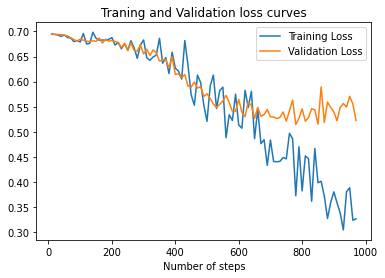

Finished Training


In [14]:
model = SiameseNetwork("absolute_substraction").cuda()
num_epochs = 25
best_val_loss = None
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
threshold = 0.5
save_path = f'cifar_net.pt'
model = model.to(device)


TRAIN(model, train_loader, valid_loader, num_epochs, criterion, optimizer, best_val_loss,threshold, device, save_path)

### 4.2.4 Evaluation

In [15]:
def eval(net, valid_loader):
    max_valid_acc = 0
    optimal_threshold = 0
    threshold_array = np.arange(0.0, 1.0, 0.02)
    for threshold in threshold_array:
        print(threshold)
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            for input1,input2, labels in tqdm(valid_loader):

                input1 = input1.to(device)
                input2 = input2.to(device)

                labels = labels.to(device)
                labels = labels.unsqueeze(1)
                labels = labels.float()

                outputs = net(input1,input2)
                preds = torch.gt(outputs, threshold).int()

                running_corrects += torch.sum(preds == labels.data)

            valid_acc = running_corrects / float(len(valid_loader.dataset))
            print("valid_acc: ", valid_acc)
            if(valid_acc > max_valid_acc):
                max_valid_acc = valid_acc
                optimal_threshold = threshold
    return max_valid_acc,optimal_threshold
                    

In [16]:
max_valid_acc,optimal_threshold = eval(model, valid_loader)

0.0



valid_acc:  tensor(0.5000, device='cuda:0')
0.02



valid_acc:  tensor(0.6243, device='cuda:0')
0.04



valid_acc:  tensor(0.6586, device='cuda:0')
0.06



valid_acc:  tensor(0.6743, device='cuda:0')
0.08



valid_acc:  tensor(0.6843, device='cuda:0')
0.1



valid_acc:  tensor(0.6914, device='cuda:0')
0.12



valid_acc:  tensor(0.6986, device='cuda:0')
0.14



valid_acc:  tensor(0.7071, device='cuda:0')
0.16



valid_acc:  tensor(0.7143, device='cuda:0')
0.18



valid_acc:  tensor(0.7214, device='cuda:0')
0.2



valid_acc:  tensor(0.7271, device='cuda:0')
0.22



valid_acc:  tensor(0.7257, device='cuda:0')
0.24



valid_acc:  tensor(0.7329, device='cuda:0')
0.26



valid_acc:  tensor(0.7371, device='cuda:0')
0.28



valid_acc:  tensor(0.7386, device='cuda:0')
0.3



valid_acc:  tensor(0.7400, device='cuda:0')
0.32



valid_acc:  tensor(0.7414, device='cuda:0')
0.34



valid_acc:  tensor(0.7443, device='cuda:0')
0.36



valid_acc:  tensor(0.7429, device='cuda:0')
0.38



valid_acc:  tensor(0.7414, device='cuda:0')
0.4



valid_acc:  tensor(0.7443, device='cuda:0')
0.42



valid_acc:  tensor(0.7471, device='cuda:0')
0.44



valid_acc:  tensor(0.7543, device='cuda:0')
0.46



valid_acc:  tensor(0.7486, device='cuda:0')
0.48



valid_acc:  tensor(0.7543, device='cuda:0')
0.5



valid_acc:  tensor(0.7543, device='cuda:0')
0.52



valid_acc:  tensor(0.7529, device='cuda:0')
0.54



valid_acc:  tensor(0.7457, device='cuda:0')
0.56



valid_acc:  tensor(0.7457, device='cuda:0')
0.58



valid_acc:  tensor(0.7443, device='cuda:0')
0.6



valid_acc:  tensor(0.7386, device='cuda:0')
0.62



valid_acc:  tensor(0.7386, device='cuda:0')
0.64



valid_acc:  tensor(0.7343, device='cuda:0')
0.66



valid_acc:  tensor(0.7257, device='cuda:0')
0.68



valid_acc:  tensor(0.7300, device='cuda:0')
0.7000000000000001



valid_acc:  tensor(0.7143, device='cuda:0')
0.72



valid_acc:  tensor(0.7086, device='cuda:0')
0.74



valid_acc:  tensor(0.6986, device='cuda:0')
0.76



valid_acc:  tensor(0.6900, device='cuda:0')
0.78



valid_acc:  tensor(0.6900, device='cuda:0')
0.8



valid_acc:  tensor(0.6786, device='cuda:0')
0.8200000000000001



valid_acc:  tensor(0.6671, device='cuda:0')
0.84



valid_acc:  tensor(0.6514, device='cuda:0')
0.86



valid_acc:  tensor(0.6229, device='cuda:0')
0.88



valid_acc:  tensor(0.6014, device='cuda:0')
0.9



valid_acc:  tensor(0.5757, device='cuda:0')
0.92



valid_acc:  tensor(0.5543, device='cuda:0')
0.9400000000000001



valid_acc:  tensor(0.5271, device='cuda:0')
0.96



valid_acc:  tensor(0.5143, device='cuda:0')
0.98



valid_acc:  tensor(0.5029, device='cuda:0')


In [17]:
print("validation accuracy: ",max_valid_acc," with threshold: ", optimal_threshold)

validation accuracy:  tensor(0.7543, device='cuda:0')  with threshold:  0.44


### Predict output

In [18]:
test_set = ImageDataset(PATH + 'test.csv', PATH + 'index.txt', PATH, transform=transform)
test_loader = DataLoader(test_set,
                         num_workers = 0,
                         batch_size=1,
                         shuffle=False)
test_df = pd.read_csv(PATH + 'test.csv')

In [20]:
predictions=[]
with torch.no_grad():
    for input1,input2, labels in tqdm(test_loader):

        input1 = input1.to(device)
        input2 = input2.to(device)

        outputs = model(input1,input2)
        preds = torch.gt(outputs, optimal_threshold).int()
        
        predictions.append(preds.cpu().numpy().ravel()[0])
        
test_df['target'] = predictions

test_df.to_csv("submission_QA8_Optimization_3.csv", index=False)#submission.csv should be placed directly in current fold.
test_df.head(50)#show the result to be committed

id1   id2  target
0   4988  4973       0
1   4958  4939       0
2   4552  4891       0
3   4509  4504       1
4   4589  4587       1
5   4635  4634       1
6   4758  4751       1
7   4544  4543       1
8   4849  4887       1
9   4929  4926       1
10  4912  4918       1
11  4705  4708       1
12  4799  4864       0
13  4763  4767       1
14  4833  4839       1
15  4533  4637       0
16  4719  4712       0
17  4969  4967       1
18  4654  4921       0
19  4575  4582       0
20  4976  4975       1
21  4915  4943       1
22  4725  4985       0
23  4967  4961       1
24  4755  4754       1
25  4825  4890       0
26  4869  4725       1
27  4892  4891       1
28  4960  4951       1
29  4508  4729       0
30  4721  4723       1
31  4956  4556       0
32  4510  4502       1
33  4515  4512       1
34  4571  4578       0
35  4897  4754       1
36  4858  4853       0
37  4842  4556       0
38  4530  4523       1
39  4582  4970       1
40  4774  4565       1
41  4562  4986       0
42  4888  4882       1
43  4651  4659       1
44  4588  4583       1
45  4769  4711       0
46  4861  4870       1
47  4510  4507       1
48  4873  4871       1
49  4604  4601       1